# Demo 1:  Regression with AutoRegressive (AR) model
This demo we will demo code for using AutoRegressive (AR) model to solve the regression problem:
-   Problem: Predict stock close price of Taiwan Semiconductor Manufacturing Company (TSMC). It means that we consider the stock close price as a time series dataset (y = f(t)),
    -   y: stock close price
    -   t: time
    -   We have to find the function f (regression problem)
-   Dataset: Stock dataset which is getting from yahoo finance database by using the yfinance package.
-   Library packages:
    -   Statsmodels (is a Python module that provides classed and functions for the estimation of many different statistical models,...)
    -   yfinance (offers a threaded and Pythonic way to download market data from Yahoo finance.)
    -   pandas (A fast and efficient dataframe object for data manipulation with integrated indexing, reading and writing data between in-memory data structures and different formats: CSV, Microsoft Excel, SQL databases)
    -   ...

Tasks Outlines:
## 0. Task 0: Preparing dataset
-   Getting the stock dataset of TSMC
-   Exploring about the dataset
-   Normalize or standardlize dataset (if needed)
-   Divide dataset to trainset and testset
## 1. Task 1: Getting model from statsmodels:
-   AutoRegressive model (AR model)
-   Training model on our trainset
## 2. Task 2: Evaluating the performance of trained model on the testset
-   Compute the metrics (quantitative measurements)
    -   Regression task: R2_score, Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), ...
## 3. Task 3: Performing a rolling regression
-   A regression with a rolling time window, it means conduct regressions over and over again, with subsamples of full sample.
*********************************************************


# Import all packages

In [38]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance
from matplotlib import pyplot as plt

from statsmodels.tsa.ar_model import AutoReg

from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
import numpy as np

## 0. Task 0: Preparing Dataset

Go to the notebook file: Demo_data_stock_yfinance.ipynb to get detail of demo code for this step

### 0.1. Getting stock data of TSMC with company Code: TSM from 2 years ago.

In [4]:
# Getting stock data of Company Name: TSMC with Company Code: TSM
"""
-   start_date: start time to getting data stock
-   end_data: end time to getting data stock
-   data_source: where to getting data
"""
now = datetime.now()
data_source = 'yahoo'
start_date = now.today() - relativedelta(years  = 2)
end_date = now.today()
print(start_date)
print(end_date)
df_TSM = yfinance.download("TSM",start=start_date,end=end_date)

2021-11-13 11:35:09.733621
2023-11-13 11:35:09.733692
[*********************100%%**********************]  1 of 1 completed


### 0.2. Exploring the data:
See the file Demo_data_stock_yfinance.ipynb for more detail.

In [5]:
# Type of data after getting from yfinance:
print(type(df_TSM))

<class 'pandas.core.frame.DataFrame'>


In [6]:
# Data info:
df_TSM.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 501 entries, 2021-11-15 to 2023-11-10
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       501 non-null    float64
 1   High       501 non-null    float64
 2   Low        501 non-null    float64
 3   Close      501 non-null    float64
 4   Adj Close  501 non-null    float64
 5   Volume     501 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 27.4 KB


In [8]:
# Showing most recently five days in our dataframe
df_TSM.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-11-06,92.000000,92.610001,91.290001,92.599998,92.599998,8402700
2023-11-07,92.250000,93.050003,91.750000,92.410004,92.410004,6241300
2023-11-08,93.330002,93.440002,91.930000,92.000000,92.000000,6537700
2023-11-09,92.629997,93.370003,91.599998,91.620003,91.620003,8166000
2023-11-10,94.040001,97.750000,93.610001,97.440002,97.440002,19281700


### 0.3. Visualize data in stock form.

In [10]:
# Preparing data to plot: range of close open, range of low high, check close >= open for each day
df_TSM["Y_price"] = (df_TSM["Open"] + df_TSM["Close"])/2
df_TSM["Y_error"] = (df_TSM["Open"] - df_TSM["Close"]).abs()/2
df_TSM["HL"] = (df_TSM["High"] + df_TSM["Low"])/2
df_TSM["HL_error"] = (df_TSM["High"] - df_TSM["Low"]).abs()/2
df_TSM["IsPositive"] = df_TSM["Close"] >= df_TSM["Open"]

In [11]:
# We only plot most recently 100 days stock data of TSMC:
data_to_plot = df_TSM.tail(100)

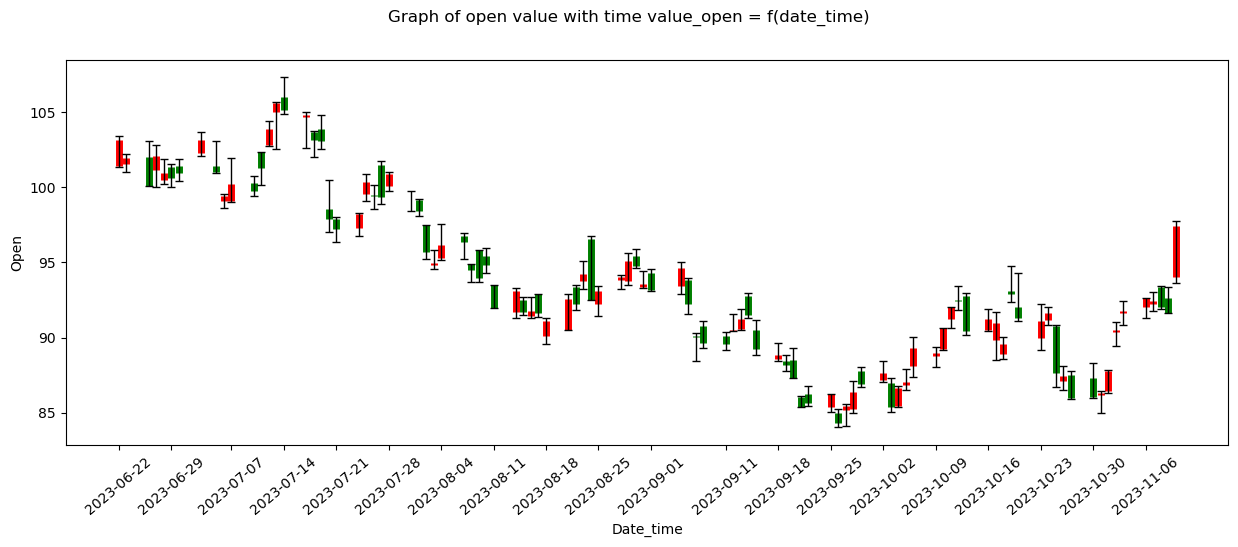

In [13]:
# Visualize data
colors = {True:'red',False:'green'}

fig, ax = plt.subplots(1,1,figsize = (15,5))
# ax.plot(plot_df_TSM.index.tolist(),plot_df_TSM["Open"],color='g')
# ax.plot(plot_df_TSM.index.tolist(),plot_df_TSM["Close"],color='red')
""" 
The following line of code plot bar range open close, color base on
the comparision of open price and close price
"""
ax.errorbar(data_to_plot.index.tolist(),
            data_to_plot["Y_price"],
            data_to_plot["Y_error"],
            linewidth = 5, 
            capsize=0,
            ls='none',
            ecolor = data_to_plot['IsPositive'].map(colors))
"""
The following line of code plot black interval with the width = high - low
"""
ax.errorbar(data_to_plot.index.tolist(),
            data_to_plot["HL"],
            data_to_plot["HL_error"],
            linewidth = 1,
            capsize=3,
            color='k',
            ls='none')

fig.suptitle("Graph of open value with time value_open = f(date_time)")
ax.set_xlabel("Date_time")
ax.set_ylabel("Open")
ax.set_xticks(data_to_plot.index.tolist()[::5]) #Without this it is too dense, with this we only display every after 5 xticks
ax.set_xticklabels(ax.get_xticklabels(),rotation = 40, ha = 'center')# Shearing the labels to 40 degree and write it in center
plt.show()

### 0.4. Prepare data for training model:
-   We consider the Close column in our data set as timeseries data
-   Divide data into two parts:
    -   For training: first 400 rows
    -   For testing: start from row 400th


In [15]:
y_train = df_TSM["Close"][:400]
y_test = df_TSM["Close"][400:]

## 1. Task 1: Getting model from statsmodels package
### 1.1. Getting model from statsmodels:
AutoRegressive is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step.

Model form: y/output = f(t/input), where y/output is the close value, t/input is time at that we want to compute the close value.
-   Take a look at slide of AutoRegression model of lecture ppt to consider the function form af AutoRegressive function (hyperparameters p/lags) trainable parameters ($\alpha, \phi _1,\phi _2,....,\phi _p $ ?)

In [19]:
# Create a AR model with lags = 10
ar_model = AutoReg(y_train,lags = 10)

/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### 1.2. Training for our model

In [ ]:
ar_model_trained = ar_model.fit()

In [17]:
# Obtain value of parameters after training/fitting
print("Coefficients:", ar_model_trained.params)

Coefficients: const        1.130019
Close.L1     1.007101
Close.L2    -0.079149
Close.L3     0.021703
Close.L4    -0.025852
Close.L5     0.178851
Close.L6    -0.047896
Close.L7    -0.005026
Close.L8    -0.031719
Close.L9    -0.047808
Close.L10    0.017237
dtype: float64


## 2. Task 2: Evaluating the performance of trained model on the testset
### 2.1. Predict the close price for time series on the test part

In [32]:
pred_test = ar_model_trained.predict(start=len(y_train),
                               end=len(y_train) + len(y_test) - 1,
                               dynamic=False)

/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/user/anaconda3/envs/ASINK_Demo/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [30]:
date_index = df_TSM.index.to_list()[400]

In [35]:
print(f"Predict Close value at time = {date_index} is:{pred_test.iloc[0]},\n true Close value is: {y_test.iloc[0]}")

Predict Close value at time = 2023-06-21 00:00:00 is:104.2905671669166,
 true Close value is: 101.63999938964844


### 2.2. Compute the metrics (quantitative measurements)

In [36]:
# R2-score:
score = r2_score(y_pred=pred_test,y_true=y_test)
print("The R2 score of our model is: ",score)

The R2 score of our model is:  0.15200487833722642


In [37]:
# Mean Absolute Error:
mae_score = mean_absolute_error(y_pred=pred_test,y_true=y_test)
print("The mean absolute error of our model is: ", mae_score)

The mean absolute error of our model is:  4.333912147267982


In [39]:
#  Root Mean Squared Error (RMSE):
rmse_score = np.sqrt(mean_squared_error(y_pred=pred_test,y_true=y_test))
print("The root mean squared error of our model is:", rmse_score)

The root mean squared error of our model is: 5.060879779472137


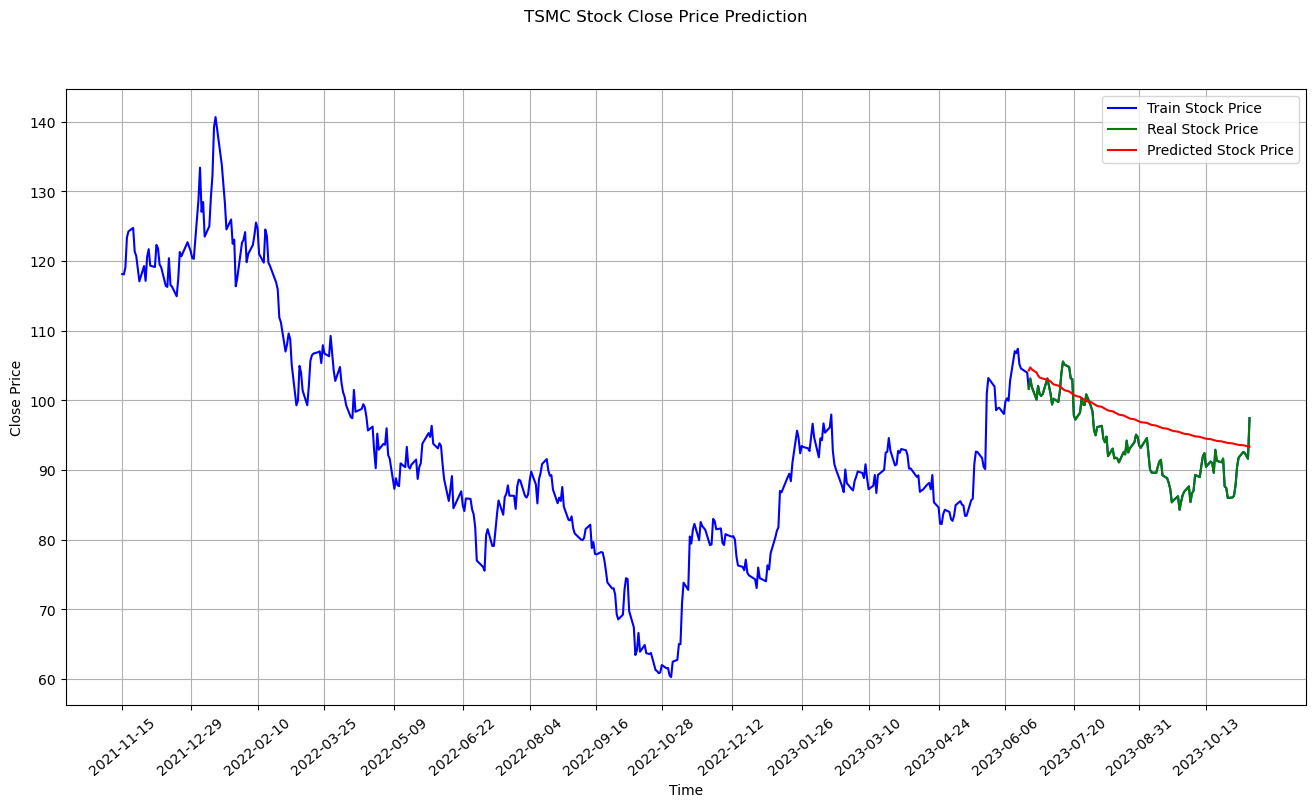

In [44]:
# Visulize the Close price
fig, ax = plt.subplots(1,1,figsize = (16,8))

ax.plot(df_TSM.index[:], df_TSM['Close'], color='blue', label = 'Train Stock Price')
ax.plot(y_test.index, y_test, color = 'green', label = 'Real Stock Price')
ax.plot(y_test.index, pred_test, color = 'red', label = 'Predicted Stock Price')
fig.suptitle('TSMC Stock Close Price Prediction')
ax.set_xlabel('Time')
ax.set_ylabel('Close Price')
ax.set_xticks(df_TSM.index.tolist()[::30]) #Without this it is too dense, with this we only display every after 30 xticks
ax.set_xticklabels(ax.get_xticklabels(),rotation = 40, ha = 'center')# Shearing the labels to 40 degree and write it in center

ax.legend()
ax.grid(True)

plt.show()

## 3. Task 3: Performing a rolling regression
A regression with a rolling time window, it means conduct regressions over and over again, with subsamples of test dataset.

In [47]:
print(y_test.iloc[0])

101.63999938964844


In [54]:
# Performing a rolling forecasts
history = [y for y in y_train]
pred_roll = []
for i in range(len(y_test)):
    # Create AR model and fit the history data to this model:
    ar_model_temp = AutoReg(history,lags=10)
    ar_trained = ar_model_temp.fit()
    # forecasts and get first forecasts (the timeseries right after history)
    y_pred = ar_trained.forecast()[0]
    # add the pred value to the list pred_roll
    pred_roll.append(y_pred)
    # update for history by appending one observation
    obs = y_test.iloc[i] # update the true close value
    history.append(obs)


In [55]:
# report performance
# R2-score:
score = r2_score(y_pred=np.array(pred_roll),y_true=np.array(y_test))
print("The R2 score of our model is: ",score)

# Mean Absolute Error:
mae_score = mean_absolute_error(y_pred=pred_roll,y_true=y_test)
print("The mean absolute error of our model is: ", mae_score)

#  Root Mean Squared Error (RMSE):
rmse_score = np.sqrt(mean_squared_error(y_pred=pred_roll,y_true=y_test))
print("The root mean squared error of our model is:", rmse_score)


The R2 score of our model is:  0.9132135613861228
The mean absolute error of our model is:  1.2466667108450922
The root mean squared error of our model is: 1.619031421189844


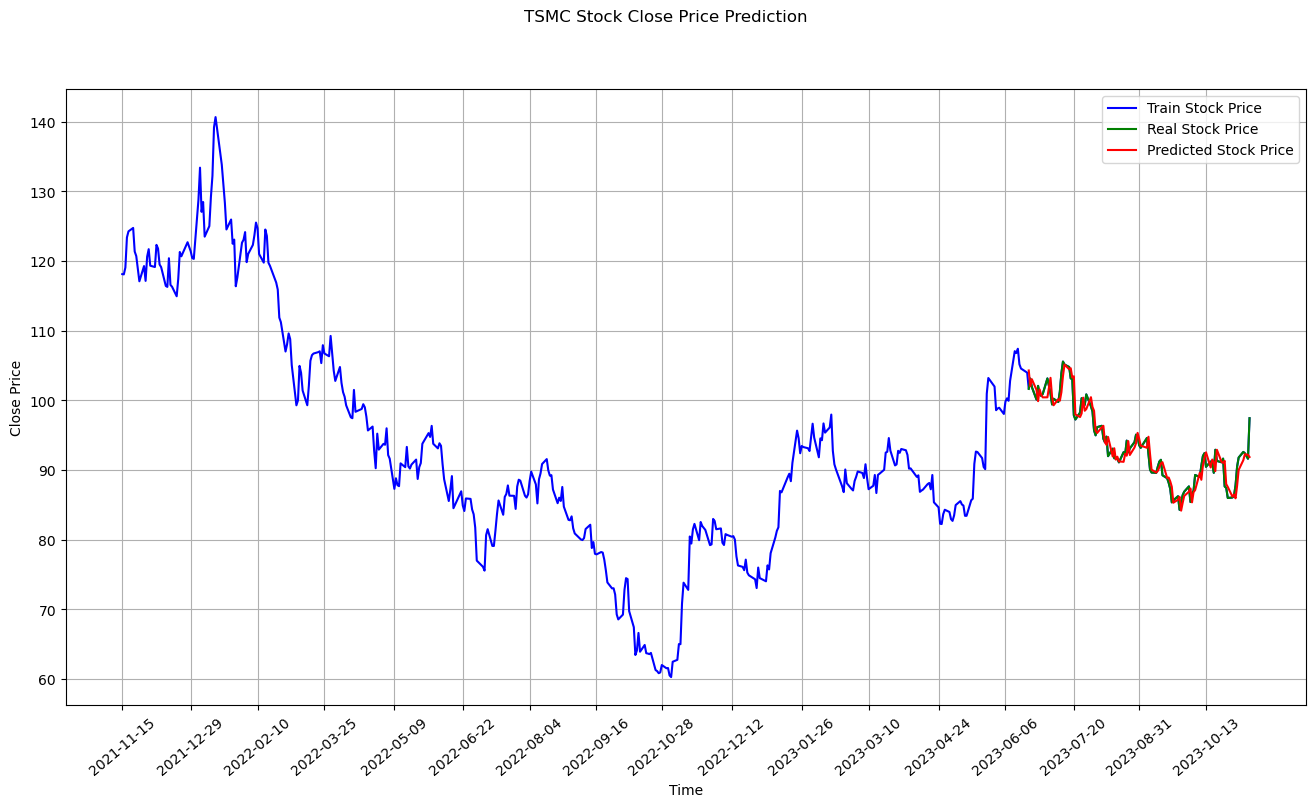

In [56]:
# Visulize the Close price
fig, ax = plt.subplots(1,1,figsize = (16,8))

ax.plot(df_TSM.index[:], df_TSM['Close'], color='blue', label = 'Train Stock Price')
ax.plot(y_test.index, y_test, color = 'green', label = 'Real Stock Price')
ax.plot(y_test.index, pred_roll, color = 'red', label = 'Predicted Stock Price')
fig.suptitle('TSMC Stock Close Price Prediction')
ax.set_xlabel('Time')
ax.set_ylabel('Close Price')
ax.set_xticks(df_TSM.index.tolist()[::30]) #Without this it is too dense, with this we only display every after 30 xticks
ax.set_xticklabels(ax.get_xticklabels(),rotation = 40, ha = 'center')# Shearing the labels to 40 degree and write it in center

ax.legend()
ax.grid(True)

plt.show()